# Feature Engineering

This notebook will focus on preparing the tickets data to move into the modeling phase as well as engineering additional features to use for modeling.

## Import Libraries

In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Read Data
Pickle files were exported from the data cleaning notebook in order to preserve datatypes. So we will read the tickets pickle file.

In [43]:
tickets = pd.read_pickle('../data/ticket_data_clean.pkl')

In [44]:
tickets.head(3)

,id,subject,description,channel,sat_score,sat_comment,ticket_id,created,updtd,grp_stations,...,solved,latest_comment_added,reply_mins,first_reso_mins,full_reso_mins,agt_wait_mins,reqstr_wait_mins,on_hold_mins,sent_score,num_comms
0,274744,PO#M16063-05,"Please find the attached order. Thanks, Cheryl...",email,bad,NaN,274744,2023-01-18 21:57:41+00:00,2023-01-18 22:21:07+00:00,1,...,2023-01-18 22:21:07+00:00,2023-01-18 22:21:07+00:00,23.0,23,23,0,23,0,0.746100,2
1,274740,"Jeff Burgess & Associates, Inc. dba JB&A: Purc...",Please open the attached file to view your Pur...,email,bad,NaN,274740,2023-01-18 21:54:34+00:00,2023-01-18 22:39:07+00:00,1,...,2023-01-18 22:39:07+00:00,2023-01-18 22:39:18+00:00,45.0,45,45,0,44,0,0.526767,3
2,274722,PO#66777 / RING-2201P,"Good afternoon, Please process the attached pu...",email,bad,NaN,274722,2023-01-18 20:28:04+00:00,2023-01-18 20:37:12+00:00,1,...,2023-01-18 20:37:12+00:00,2023-01-18 20:37:12+00:00,9.0,9,9,0,9,0,0.776250,2


In [45]:
tickets.shape

(13323, 28)

In [46]:
tickets.columns

Index(['id', 'subject', 'description', 'channel', 'sat_score', 'sat_comment',
       'ticket_id', 'created', 'updtd', 'grp_stations', 'asign_stations',
       'reopens', 'replies', 'asign_updtd', 'reqstr_updtd', 'status_updtd',
       'initially_assigned', 'assigned', 'solved', 'latest_comment_added',
       'reply_mins', 'first_reso_mins', 'full_reso_mins', 'agt_wait_mins',
       'reqstr_wait_mins', 'on_hold_mins', 'sent_score', 'num_comms'],
      dtype='object')

In [47]:
tickets.dtypes

id                                    int64
subject                              object
description                          object
channel                              object
sat_score                            object
sat_comment                          object
ticket_id                             int64
created                 datetime64[ns, UTC]
updtd                   datetime64[ns, UTC]
grp_stations                          int64
asign_stations                        int64
reopens                               int64
replies                               int64
asign_updtd             datetime64[ns, UTC]
reqstr_updtd            datetime64[ns, UTC]
status_updtd            datetime64[ns, UTC]
initially_assigned      datetime64[ns, UTC]
assigned                datetime64[ns, UTC]
solved                  datetime64[ns, UTC]
latest_comment_added    datetime64[ns, UTC]
reply_mins                          float64
first_reso_mins                       int64
full_reso_mins                  

In [48]:
tickets.isna().sum()[tickets.isna().sum() > 0]

sat_comment    9035
dtype: int64

## Initial Feature Trim

There were some features that were useful for EDA, but won't be used in modeling.  I will drop these features.  There are likely other features that may be dropped later, but they may be used for feature engineering, so I'll wait until that is complete before dropping additional features.


In [49]:
drop_feats = [
    'id',
    'subject',
    'description',
    'sat_comment',
    'ticket_id'
]

tickets = tickets.drop(columns=drop_feats)

In [50]:
tickets.shape

(13323, 23)

In [51]:
tickets.head(3)

,channel,sat_score,created,updtd,grp_stations,asign_stations,reopens,replies,asign_updtd,reqstr_updtd,...,solved,latest_comment_added,reply_mins,first_reso_mins,full_reso_mins,agt_wait_mins,reqstr_wait_mins,on_hold_mins,sent_score,num_comms
0,email,bad,2023-01-18 21:57:41+00:00,2023-01-18 22:21:07+00:00,1,1,0,1,2023-01-18 22:21:07+00:00,2023-01-20 10:00:20+00:00,...,2023-01-18 22:21:07+00:00,2023-01-18 22:21:07+00:00,23.0,23,23,0,23,0,0.746100,2
1,email,bad,2023-01-18 21:54:34+00:00,2023-01-18 22:39:07+00:00,1,1,0,1,2023-01-18 22:39:18+00:00,2023-01-20 10:00:19+00:00,...,2023-01-18 22:39:07+00:00,2023-01-18 22:39:18+00:00,45.0,45,45,0,44,0,0.526767,3
2,email,bad,2023-01-18 20:28:04+00:00,2023-01-18 20:37:12+00:00,1,1,0,1,2023-01-18 20:37:12+00:00,2023-01-20 08:00:16+00:00,...,2023-01-18 20:37:12+00:00,2023-01-18 20:37:12+00:00,9.0,9,9,0,9,0,0.776250,2


## Transform Target
Change target from a string value to a numeric value

In [52]:
tickets['sat_score'] = tickets['sat_score'].map({'good': 1,
                                                 'bad': 0})

## Feature Creation

We have certain time-based data represented in some of the minute count features that were existing in the dataset, like first reply time, full resolution, etc.  I'd like to explore what some of the key elements may be that might contribute to satisfaction ratings, such as:
* Time from ticket creation to first assignment
* Time from first assignment to ticket solved

Using some of the columns we already have, let's calculate some other deltas/counts as they might be useful for modeling. Because we have other data in this set in minutes, we'll calculate the difference in minutes.  This way when moving to modeling, many of these features will be on a similar scale.

In addition to some of the time delta calculations, I'd also like to create a representation of a frequency of comments over the course of the ticket, such as comments / total minutes.

### Created to Initially Assigned

Calculate the delta, in minutes, between when a ticket was created and when it was initially assigned.

In [53]:
tickets.columns

Index(['channel', 'sat_score', 'created', 'updtd', 'grp_stations',
       'asign_stations', 'reopens', 'replies', 'asign_updtd', 'reqstr_updtd',
       'status_updtd', 'initially_assigned', 'assigned', 'solved',
       'latest_comment_added', 'reply_mins', 'first_reso_mins',
       'full_reso_mins', 'agt_wait_mins', 'reqstr_wait_mins', 'on_hold_mins',
       'sent_score', 'num_comms'],
      dtype='object')

In [54]:
# timedelta hint from
# https://stackoverflow.com/questions/22923775/calculate-time-difference-between-two-pandas-columns-in-hours-and-minutes

tickets['td_crtd_assnd'] = (tickets['initially_assigned']
                            - tickets['created']
                           ).astype('timedelta64[m]')

Check that the code above produces the desired output:

In [55]:
tickets[['created', 'initially_assigned', 'td_crtd_assnd']].head(3)

,created,initially_assigned,td_crtd_assnd
0,2023-01-18 21:57:41+00:00,2023-01-18 22:05:08+00:00,7.0
1,2023-01-18 21:54:34+00:00,2023-01-18 22:04:51+00:00,10.0
2,2023-01-18 20:28:04+00:00,2023-01-18 20:35:06+00:00,7.0


Explore the feature:

In [56]:
tickets['td_crtd_assnd'].describe()

count     13323.000000
mean        849.948960
std        6237.757671
min          -1.000000
25%          59.000000
50%         198.000000
75%         531.000000
max      432974.000000
Name: td_crtd_assnd, dtype: float64

In [57]:
tickets['td_crtd_assnd'].skew()

43.71633025454238

Different from the created to solved time data, the median value is lower than the mean.  This still has a very wide range of values and has a high positive skew, so I would expect to see another long right tail here.

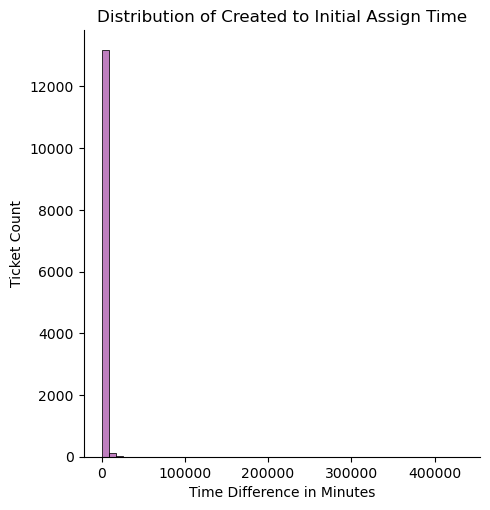

In [58]:
sns.displot(
    tickets['td_crtd_assnd'],
    kind='hist',
    bins=50,
    color='purple',
    alpha=0.5
).set(
    title='Distribution of Created to Initial Assign Time',
    xlabel='Time Difference in Minutes',
    ylabel='Ticket Count'
);

It looks like distribution has similar characteristics to many of the other features we've looked at.  Let's also try to 'zoom in' a bit and see this in more detail.  This one may be a bit more interesting given what was seen in the descriptive statistics in relationship between the median and mean values.

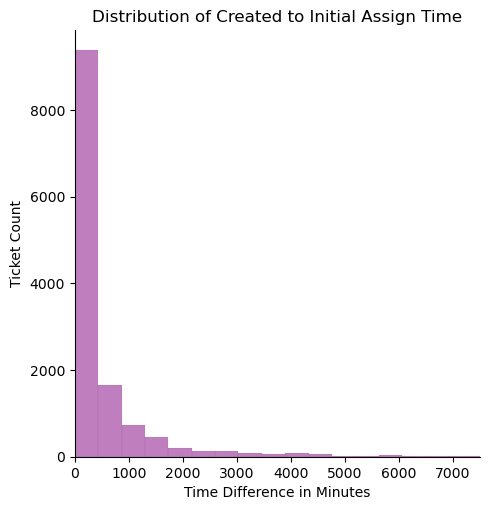

In [59]:
# zoom in
sns.displot(
    tickets['td_crtd_assnd'],
    kind='hist',
    bins=1000,
    color='purple',
    alpha=0.5
).set(
    title='Distribution of Created to Initial Assign Time',
    xlabel='Time Difference in Minutes',
    ylabel='Ticket Count',
    xlim=(0, 7500)
);

In this plot, where the bin count has been increased and the X-axis has been limited to mean + ~1 standard deviation, we see the high concentration at the lower end of the time values, and then between 1000 and 2000 minutes a taper down to very low ticket counts, but they continue to be wispy throughout the long, right-skewed tail.

### Initially Assigned to Solved
Calculate the delta, in minutes, between when a ticket is initially assigned to when it is solved.

In [60]:
tickets['td_assnd_slvd'] = (tickets['solved'] 
                            - tickets['initially_assigned']
                           ).astype('timedelta64[m]')

Check that the code above produces the desired output:

In [61]:
tickets[['initially_assigned', 'solved', 'td_assnd_slvd']].head(3)

,initially_assigned,solved,td_assnd_slvd
0,2023-01-18 22:05:08+00:00,2023-01-18 22:21:07+00:00,15.0
1,2023-01-18 22:04:51+00:00,2023-01-18 22:39:07+00:00,34.0
2,2023-01-18 20:35:06+00:00,2023-01-18 20:37:12+00:00,2.0


Explore the feature:

In [62]:
tickets['td_assnd_slvd'].describe()

count    1.332300e+04
mean     2.133127e+04
std      7.584771e+04
min     -4.403000e+03
25%      7.495000e+02
50%      7.233000e+03
75%      1.168600e+04
max      2.286929e+06
Name: td_assnd_slvd, dtype: float64

In [63]:
tickets['td_assnd_slvd'].skew()

13.385191409153485

Given the range of values, the median being larger than the mean, and the relatively large standard deviation, this data also looks to be concentrated at low values, and have a significant right-skewed tail.

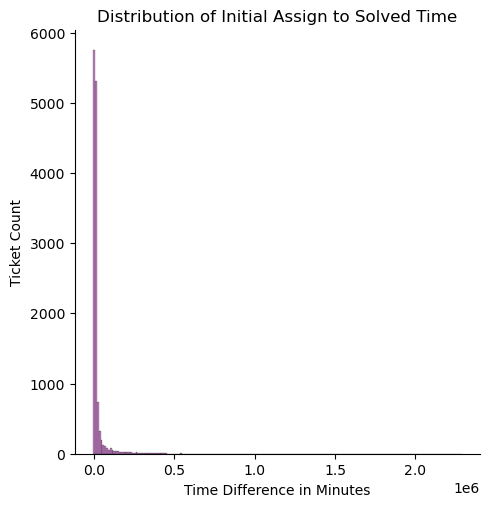

In [64]:
sns.displot(
    tickets['td_assnd_slvd'],
    kind='hist',
    bins=200,
    color='purple',
    alpha=0.5
).set(
    title='Distribution of Initial Assign to Solved Time',
    xlabel='Time Difference in Minutes',
    ylabel='Ticket Count'
);

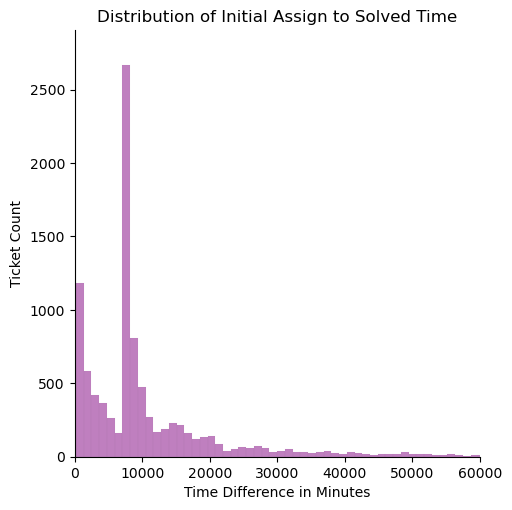

In [65]:
sns.displot(
    tickets['td_assnd_slvd'],
    kind='hist',
    bins=2000,
    color='purple',
    alpha=0.5
).set(
    title='Distribution of Initial Assign to Solved Time',
    xlabel='Time Difference in Minutes',
    ylabel='Ticket Count',
    xlim=(0, 6e+04)
);

Like the previous feature plot, when we increase the bin count and restrict the X-axis to mean + .5 standard deviation, this distribution has bimodal characteristics but the peak in the lower values doesn't have the same magnitude.  We see the largest peak around ~7500 minutes, and then the counts taper off around 20,0000 minutes but there are low levels of activity throughout the long, right-skewed tail.

The bimodality that we've seen in these plots may be attributed to how the different teams that interface with tickets operate.  For example, tickets fielded by the Orders team are typically low touch and low interaction, so those tickets are more actively assigned and subsequently solved than tickets to the Support team, where tickets may sit longer before being assigned to an agent.

### Reply and Comment Rate

As mentioned, we have a feature that is a count of the replies sent to the customer, and a feature that is the overall count of all comments on the ticket.  Dividing these counts by the total number of minutes will give us a frequency rate to use in modeling.

In [66]:
tickets['rply_rate'] = tickets['replies'] / tickets['full_reso_mins']
tickets['comm_rate'] = tickets['num_comms'] / tickets['full_reso_mins']

Check that the code above produces the desired output:

In [67]:
tickets.head(3)

,channel,sat_score,created,updtd,grp_stations,asign_stations,reopens,replies,asign_updtd,reqstr_updtd,...,full_reso_mins,agt_wait_mins,reqstr_wait_mins,on_hold_mins,sent_score,num_comms,td_crtd_assnd,td_assnd_slvd,rply_rate,comm_rate
0,email,0,2023-01-18 21:57:41+00:00,2023-01-18 22:21:07+00:00,1,1,0,1,2023-01-18 22:21:07+00:00,2023-01-20 10:00:20+00:00,...,23,0,23,0,0.746100,2,7.0,15.0,0.043478,0.086957
1,email,0,2023-01-18 21:54:34+00:00,2023-01-18 22:39:07+00:00,1,1,0,1,2023-01-18 22:39:18+00:00,2023-01-20 10:00:19+00:00,...,45,0,44,0,0.526767,3,10.0,34.0,0.022222,0.066667
2,email,0,2023-01-18 20:28:04+00:00,2023-01-18 20:37:12+00:00,1,1,0,1,2023-01-18 20:37:12+00:00,2023-01-20 08:00:16+00:00,...,9,0,9,0,0.776250,2,7.0,2.0,0.111111,0.222222


Explore the feature:

In [68]:
tickets[['rply_rate', 'comm_rate']].describe()

,rply_rate,comm_rate
count,1.330400e+04,1.332300e+04
mean,inf,inf
std,NaN,NaN
min,0.000000e+00,2.441359e-06
25%,1.338643e-04,2.786583e-04
50%,2.826123e-04,7.103955e-04
75%,1.213040e-03,3.284072e-03
max,inf,inf


It looks like the calculates produced values of infinity, most likely becuase there was a 0 value in the calculations.

In [69]:
tickets.describe()

,sat_score,grp_stations,asign_stations,reopens,replies,reply_mins,first_reso_mins,full_reso_mins,agt_wait_mins,reqstr_wait_mins,on_hold_mins,sent_score,num_comms,td_crtd_assnd,td_assnd_slvd,rply_rate,comm_rate
count,13323.000000,13323.000000,13323.000000,13323.000000,13323.000000,13323.000000,1.332300e+04,1.332300e+04,13323.000000,1.332300e+04,1.332300e+04,13323.000000,13323.000000,13323.000000,1.332300e+04,1.330400e+04,1.332300e+04
mean,0.854612,1.078961,1.068828,0.286947,2.684606,1380.416648,1.693274e+04,2.218217e+04,5350.052541,1.656972e+04,3.501747e+03,0.488628,6.431810,849.948960,2.133127e+04,inf,inf
std,0.352505,0.512487,0.331262,0.581582,3.146151,9926.571312,6.160425e+04,7.632308e+04,8926.392130,7.541863e+04,5.080692e+04,0.267261,7.662315,6237.757671,7.584771e+04,NaN,NaN
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,-0.975850,1.000000,-1.000000,-4.403000e+03,0.000000e+00,2.441359e-06
25%,1.000000,1.000000,1.000000,0.000000,1.000000,67.000000,7.830000e+02,1.389000e+03,4.000000,2.190000e+02,0.000000e+00,0.325095,2.000000,59.000000,7.495000e+02,1.338643e-04,2.786583e-04
50%,1.000000,1.000000,1.000000,0.000000,2.000000,209.000000,7.310000e+03,7.454000e+03,3870.000000,9.320000e+02,0.000000e+00,0.507200,4.000000,198.000000,7.233000e+03,2.826123e-04,7.103955e-04
75%,1.000000,1.000000,1.000000,0.000000,3.000000,564.000000,9.953000e+03,1.302100e+04,7276.000000,4.355000e+03,0.000000e+00,0.687813,8.000000,531.000000,1.168600e+04,1.213040e-03,3.284072e-03
max,1.000000,21.000000,10.000000,7.000000,122.000000,409608.000000,2.253693e+06,2.286965e+06,234467.000000,2.286886e+06,2.189366e+06,0.999700,270.000000,432974.000000,2.286929e+06,inf,inf


It looks like only the rate calculations have nulls and infinity values.  Checking to see how many:

In [70]:
len((
    tickets
    [(tickets['rply_rate'] == np.inf) | 
     (tickets['comm_rate'] == np.inf) |
     (tickets['rply_rate'].isna()) |
     (tickets['rply_rate'].isna())
    ]
))

21

Looks like only 21 records, so we will fill those.

In [71]:
tickets = tickets.fillna(0)

In [72]:
tickets = tickets.replace(np.inf, 0)

Check to make sure that worked:

In [73]:
len((
    tickets
    [(tickets['rply_rate'] == np.inf) | 
     (tickets['comm_rate'] == np.inf) |
     (tickets['rply_rate'].isna()) |
     (tickets['rply_rate'].isna())
    ]
))

0

In [74]:
tickets[['rply_rate', 'comm_rate']].describe()

,rply_rate,comm_rate
count,13323.000000,13323.000000
mean,0.006018,0.013260
std,0.049079,0.089262
min,0.000000,0.000000
25%,0.000134,0.000277
50%,0.000281,0.000707
75%,0.001209,0.003233
max,3.000000,4.000000


These features have very similar characteristics to most of the other features we've seen, so I will just go straight to a zoomed in look for these distributions.

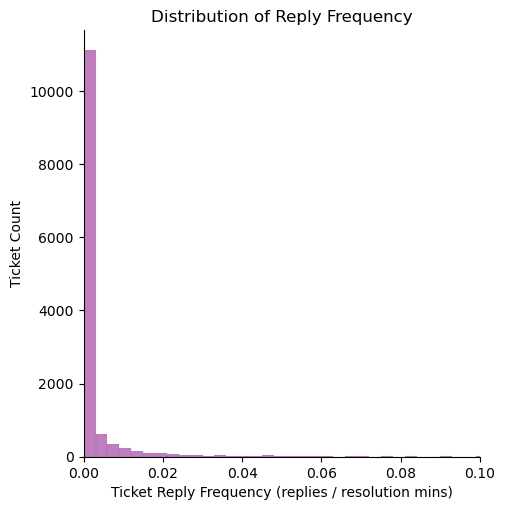

In [75]:
sns.displot(
    tickets['rply_rate'],
    kind='hist',
    bins=1000,
    color='purple',
    alpha=0.5
).set(
    title='Distribution of Reply Frequency',
    xlabel='Ticket Reply Frequency (replies / resolution mins)',
    ylabel='Ticket Count',
    xlim=(0, .1)
);

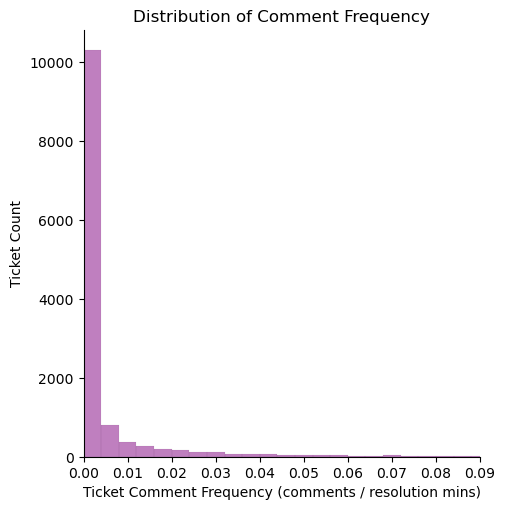

In [76]:
sns.displot(
    tickets['comm_rate'],
    kind='hist',
    bins=1000,
    color='purple',
    alpha=0.5
).set(
    title='Distribution of Comment Frequency',
    xlabel='Ticket Comment Frequency (comments / resolution mins)',
    ylabel='Ticket Count',
    xlim=(0, .09)
);

Given what we saw during eda with some very high resolution times and lower concentrations in both reply and comment counts, it's not surprising that these values are small and concentrated, but these are features represented in a slightly different way that may be useful in modeling.

### Check for Nulls
Since we have created some new features, let's make sure there aren't any new null values in the data.

In [77]:
tickets.isna().sum()[tickets.isna().sum() > 0]

Series([], dtype: int64)

## Check Correlation
Look for collinear features.  Even if we use a random forest model, having multiple features that represent similar characteristics may not be the best for modeling.

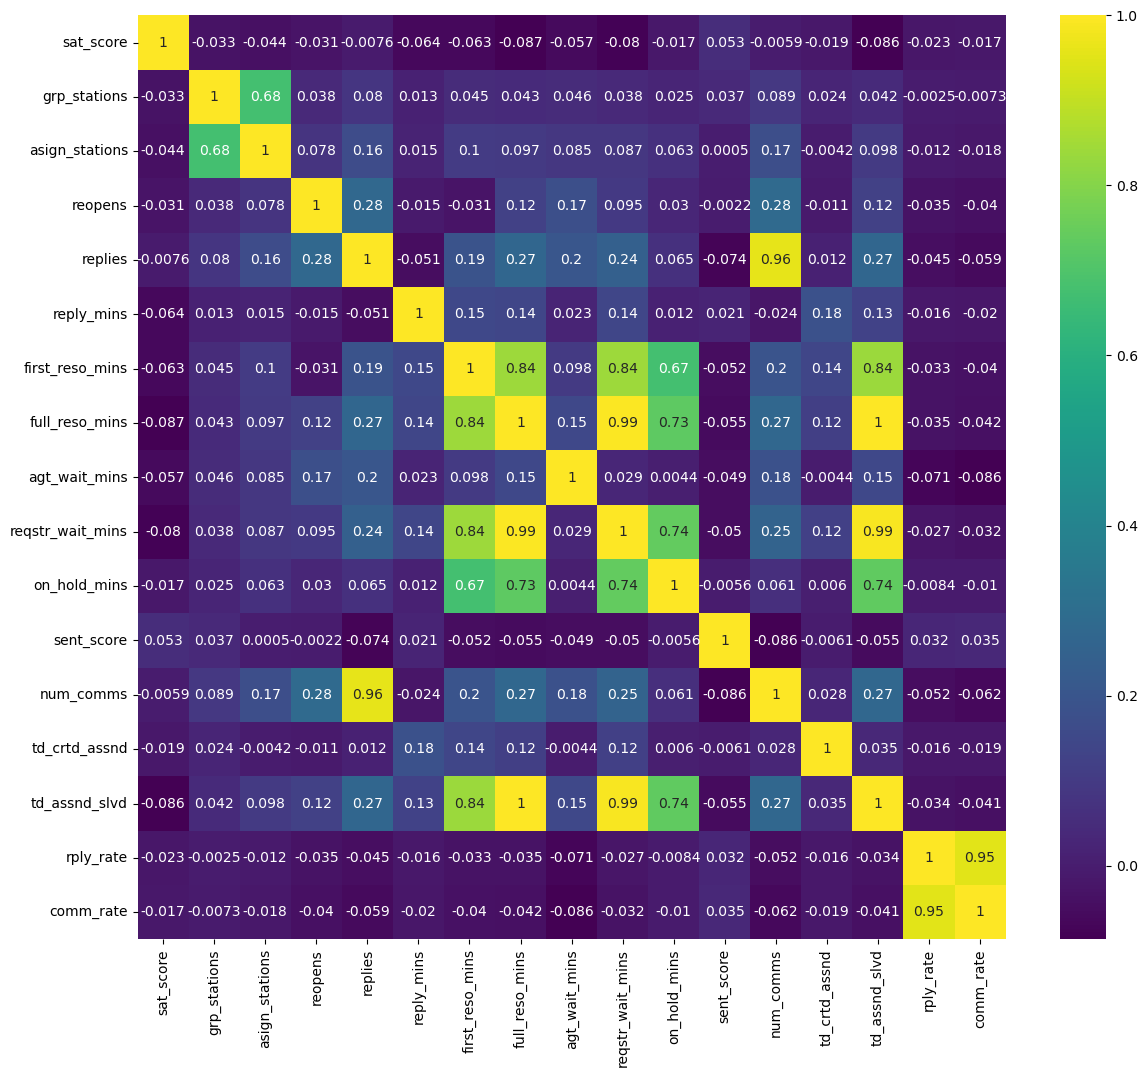

In [78]:
plt.figure(figsize=(14,12))
sns.heatmap(tickets.corr(numeric_only=True),
            annot=True,
            cmap='viridis');

Although I do see some features that are highly correlated with each other, since the project has been quite non-linear, I've already implemented some algorithmic feature selection in the next notebook, using some of these features that have higher correlation values.  At this point, I'll make a note of them, but proceed with the rest of this notebook as-is, and make sure I document this as a potential next step.

Features of note:
* `td_assnd_slvd` and `full_reso_mins` = 1
* `td_assnd_slvd` and `rqstr_wait_mins` = .99
* `num_comms` and `replies` = .96
* `comm_rate` and `rply_rate` = .95
* `rqstr_wait_mins` and `full_reso_mins` = .99

## Final Feature Drop

* Channel
* Timestamps
* Collinear features (on hold--see note above)

In [79]:
tickets = tickets.drop(
    columns=[
        'created',
        'updtd',
        'asign_updtd',
        'reqstr_updtd',
        'status_updtd',
        'initially_assigned',
        'assigned',
        'solved',
        'latest_comment_added',
        'channel'
])

In [80]:
tickets.columns

Index(['sat_score', 'grp_stations', 'asign_stations', 'reopens', 'replies',
       'reply_mins', 'first_reso_mins', 'full_reso_mins', 'agt_wait_mins',
       'reqstr_wait_mins', 'on_hold_mins', 'sent_score', 'num_comms',
       'td_crtd_assnd', 'td_assnd_slvd', 'rply_rate', 'comm_rate'],
      dtype='object')

In [81]:
tickets.head(3)

,sat_score,grp_stations,asign_stations,reopens,replies,reply_mins,first_reso_mins,full_reso_mins,agt_wait_mins,reqstr_wait_mins,on_hold_mins,sent_score,num_comms,td_crtd_assnd,td_assnd_slvd,rply_rate,comm_rate
0,0,1,1,0,1,23.0,23,23,0,23,0,0.746100,2,7.0,15.0,0.043478,0.086957
1,0,1,1,0,1,45.0,45,45,0,44,0,0.526767,3,10.0,34.0,0.022222,0.066667
2,0,1,1,0,1,9.0,9,9,0,9,0,0.776250,2,7.0,2.0,0.111111,0.222222


## Export
The tickets data will be used for modeling so will export it for use where needed.

In [82]:
tickets.to_pickle('../data/modeling_data.pkl')